# Import the libraries:

In [1]:
# matplotlib configuration
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dx
import datetime
import scipy.optimize as spo
from market_valuation.market_val_utils import get_option_chain_and_price

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(context='notebook', 
              style='whitegrid',
              palette='colorblind', 
              color_codes=True, 
              rc={'figure.figsize': [10, 6]})

# Load market data:

In [2]:
symbol = "TSLA"
desired_expiry_date_dateObject = datetime.date(2025, 9, 19)
option_data = get_option_chain_and_price(symbol, desired_expiry_date_dateObject)

if option_data:
    print(f"Option chain and current price for {symbol} expiring on {desired_expiry_date_dateObject}:")
    print(f"Current Price: {option_data['current_price']}")
    print("Calls:")
    print(option_data["calls"])
    print("\nPuts:")
    print(option_data["puts"])
else:
    print(f"Could not retrieve option chain or price for {symbol} on {desired_expiry_date_dateObject}.")

Option chain and current price for TSLA expiring on 2025-09-19:
Current Price: 241.38
Calls:
          contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0    TSLA250919C00005000 2025-04-15 14:36:50+00:00     5.0     251.03    0.00   
1    TSLA250919C00010000 2024-12-20 16:19:51+00:00    10.0     431.30  384.05   
2    TSLA250919C00015000 2025-03-28 19:20:07+00:00    15.0     248.79    0.00   
3    TSLA250919C00020000 2025-03-26 19:51:14+00:00    20.0     251.47    0.00   
4    TSLA250919C00025000 2025-03-27 13:54:18+00:00    25.0     254.18    0.00   
..                   ...                       ...     ...        ...     ...   
142  TSLA250919C00920000 2025-04-16 13:39:06+00:00   920.0       0.42    0.00   
143  TSLA250919C00930000 2025-04-10 14:03:29+00:00   930.0       0.48    0.00   
144  TSLA250919C00940000 2025-04-17 18:18:01+00:00   940.0       0.32    0.00   
145  TSLA250919C00950000 2025-04-16 17:48:13+00:00   950.0       0.32    0.00   
146  TSLA250919C

# Perform data wrangling:

In [3]:
calls = option_data["calls"]
calls['EXPIR_DATE'] = datetime.date(2025, 9, 19)
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.strftime('%Y-%m-%d')
initial_value = option_data['current_price']

In [4]:
for col in ['lastTradeDate', 'EXPIR_DATE']:
    calls[col] = calls[col].apply(lambda date: pd.Timestamp(date))
    
cols = ['contractSymbol', 'lastTradeDate', 'EXPIR_DATE', 'strike', 'lastPrice', 'impliedVolatility']
calls = calls[cols]
    
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   contractSymbol     147 non-null    object        
 1   lastTradeDate      147 non-null    datetime64[ns]
 2   EXPIR_DATE         147 non-null    datetime64[ns]
 3   strike             147 non-null    float64       
 4   lastPrice          147 non-null    float64       
 5   impliedVolatility  147 non-null    float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 7.0+ KB


# Relevant Market Data

In [5]:
limit = 75
option_selection = calls[abs(calls['strike'] - initial_value) < limit].copy()
option_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 33 to 62
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   contractSymbol     30 non-null     object        
 1   lastTradeDate      30 non-null     datetime64[ns]
 2   EXPIR_DATE         30 non-null     datetime64[ns]
 3   strike             30 non-null     float64       
 4   lastPrice          30 non-null     float64       
 5   impliedVolatility  30 non-null     float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 1.6+ KB


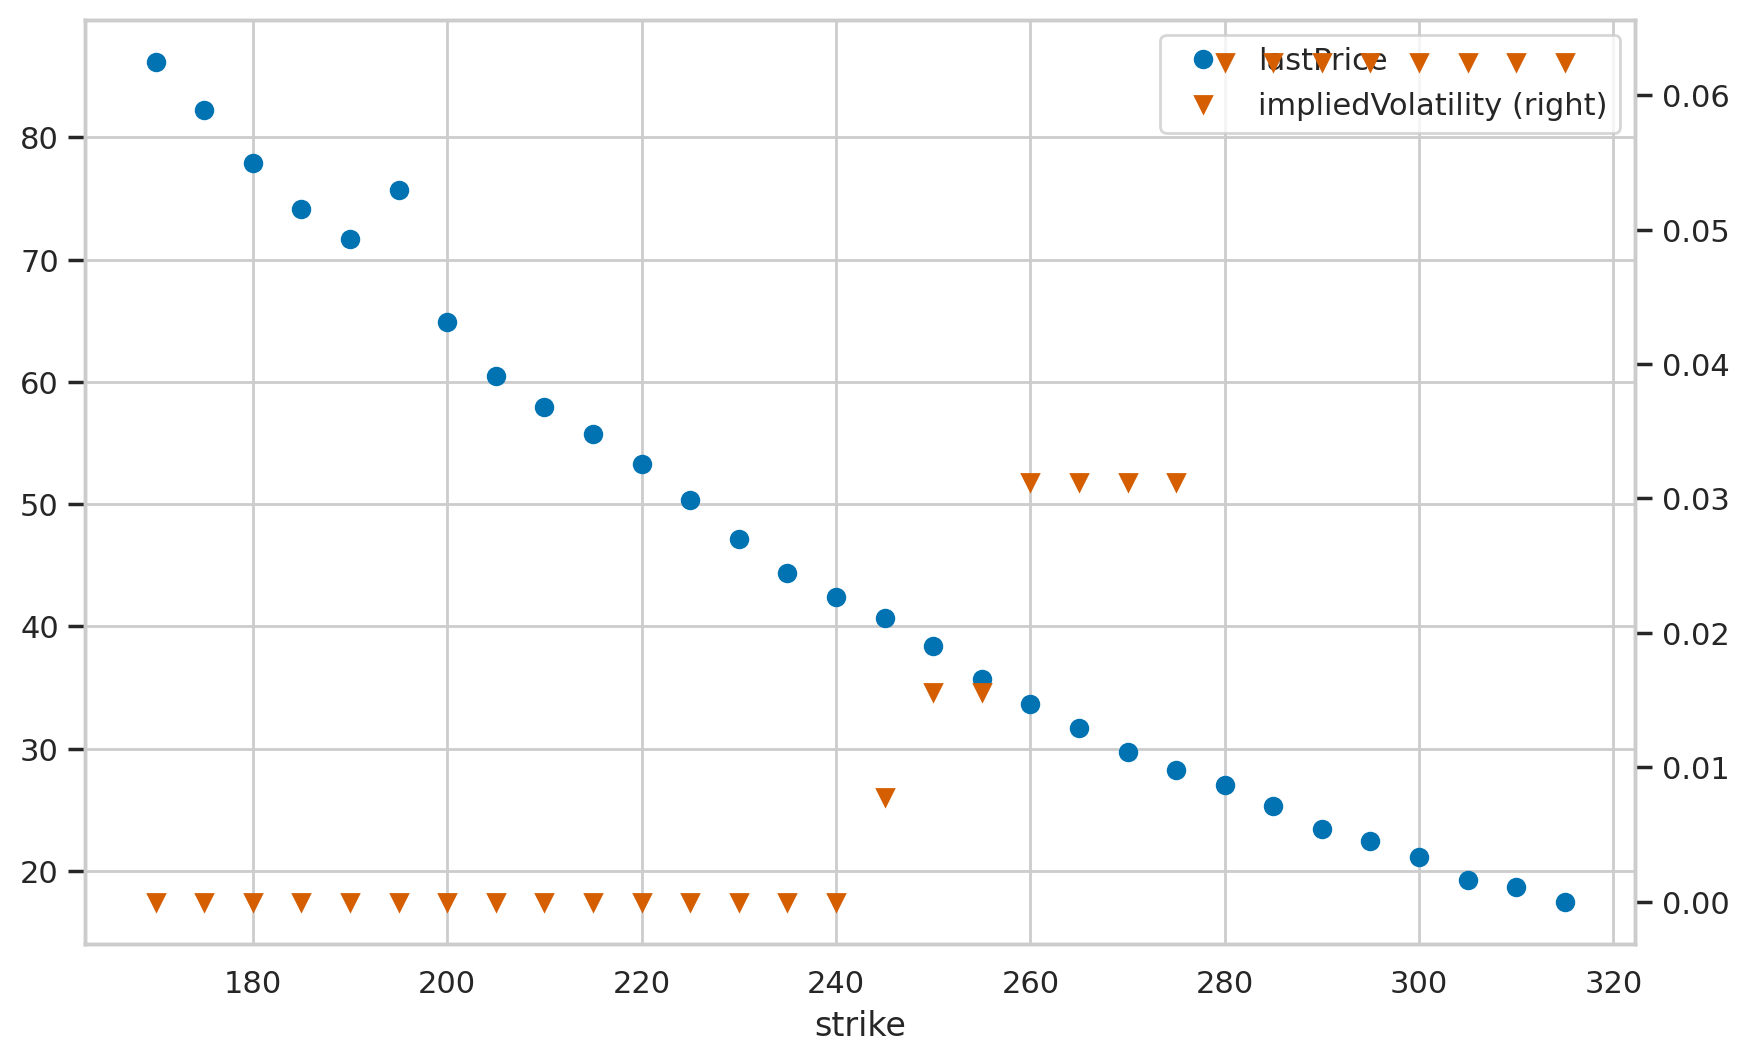

In [6]:
option_selection.set_index('strike')[['lastPrice', 'impliedVolatility']].plot(
    secondary_y='impliedVolatility', style=['bo', 'rv']
);

# Option Modelling

In [7]:
pricing_date = option_selection['lastTradeDate'].max()
me_tsla = dx.market_environment('TLSA', pricing_date)
maturity = pd.Timestamp(calls.iloc[0]['EXPIR_DATE'])

# add basic model parameters
me_tsla.add_constant('initial_value', initial_value)
me_tsla.add_constant('final_date', maturity)
me_tsla.add_constant('currency', 'USD')

In [8]:
# add simulated related parameters
me_tsla.add_constant('frequency', 'B')
me_tsla.add_constant('paths', 25_000)

In [9]:
csr = dx.constant_short_rate('csr', 0.04239) # 6-month T-bill rate
me_tsla.add_curve('discount_curve', csr)

In [10]:
# add model specific parameters for jump diffusion
me_tsla.add_constant('volatility', 0.2)
me_tsla.add_constant('lambda', 0.8)
me_tsla.add_constant('mu', -0.2)
me_tsla.add_constant('delta', 0.1)

In [11]:
tsla_model = dx.jump_diffusion('tsla_model', me_tsla)

In [12]:
# get first approximation value
me_tsla.add_constant('strike', initial_value)
me_tsla.add_constant('maturity', maturity)

In [13]:
payoff_func = 'np.maximum(maturity_value - strike, 0)'

In [14]:
# instantiate valuation object
tsla_eur_call = dx.valuation_mcs_european('tsla_eur_call', tsla_model, me_tsla, payoff_func)

In [15]:
# initiates the simulation and value estimation
%time tsla_eur_call.present_value()

CPU times: user 137 ms, sys: 68.9 ms, total: 206 ms
Wall time: 205 ms


18.774534

In [16]:
option_models = {}
for option in option_selection.index:
    strike = option_selection['strike'].loc[option]
    me_tsla.add_constant('strike',strike)
    option_models[strike] = dx.valuation_mcs_european('eur_call_%d' % strike, tsla_model, me_tsla, payoff_func)

In [17]:
def calculate_model_values(p0):
    volatility, lamb, mu, delta = p0
    tsla_model.update(volatility=volatility, lamb=lamb, mu=mu, delta=delta)
    return {strike: model.present_value(fixed_seed=True) for strike, model in option_models.items()}

# Calibration Procedure

In [18]:
i = 0
def mean_squared_error(p0): 
    global i
    model_values = np.array(list(calculate_model_values(p0).values()))
    market_values = option_selection['lastPrice'].values
    option_diffs = model_values - market_values
    MSE = np.sum(option_diffs ** 2) / len(option_diffs)
    if i % 75 == 0:
        if i == 0:
            print('%4s %6s %6s %6s %6s --> %6s' % ('i', 'vola', 'lambda', 'mu', 'delta', 'MSE'))
        print('%4d %6.3f %6.3f %6.3f %6.3f --> %6.3f' % (i, p0[0], p0[1], p0[2], p0[3], MSE))
    i += 1
    return MSE

In [19]:
%%time
i = 0
opt_global = spo.brute(mean_squared_error, 
                       ((0.4, 0.601, 0.025), # range for volatility
                        (0.1, 0.8, 0.1), # range of jump intensity
                        (-0.4, 0.01, 0.1), # range of average jump size
                        (0.00, 0.121, 0.02)), # range of jump volatility
                       finish=None)

   i   vola lambda     mu  delta -->    MSE
   0  0.400  0.100 -0.400  0.000 --> 155.541
  75  0.400  0.300 -0.400  0.100 --> 120.547
 150  0.400  0.500 -0.300  0.060 --> 117.613
 225  0.400  0.700 -0.200  0.020 --> 133.770
 300  0.425  0.200 -0.200  0.120 --> 131.094
 375  0.425  0.400 -0.100  0.080 --> 132.876
 450  0.425  0.600  0.000  0.040 --> 140.510
 525  0.450  0.200 -0.400  0.000 --> 87.971
 600  0.450  0.400 -0.400  0.100 --> 60.193
 675  0.450  0.600 -0.300  0.060 --> 65.473
 750  0.475  0.100 -0.200  0.020 --> 83.808
 825  0.475  0.300 -0.200  0.120 --> 73.097
 900  0.475  0.500 -0.100  0.080 --> 77.901
 975  0.475  0.700  0.000  0.040 --> 87.012
1050  0.500  0.300 -0.400  0.000 --> 38.194
1125  0.500  0.500 -0.400  0.100 --> 22.155
1200  0.500  0.700 -0.300  0.060 --> 25.926
1275  0.525  0.200 -0.200  0.020 --> 41.780
1350  0.525  0.400 -0.200  0.120 --> 32.544
1425  0.525  0.600 -0.100  0.080 --> 37.999
1500  0.550  0.100  0.000  0.040 --> 30.461
1575  0.550  0.400 -0.400

In [20]:
mean_squared_error(opt_global)

3.1060989328014075

In [21]:
%%time
i = 0
opt_local = spo.fmin(mean_squared_error, opt_global, xtol=0.00001, ftol=0.00001, maxiter=750, maxfun=550)

   i   vola lambda     mu  delta -->    MSE
   0  0.550  0.700 -0.400  0.120 -->  3.106
  75  0.550  0.700 -0.421  0.120 -->  2.850
 150  0.550  0.700 -0.436  0.118 -->  2.786
 225  0.548  0.700 -0.436  0.116 -->  2.753
 300  0.539  0.700 -0.471  0.104 -->  2.586
 375  0.477  0.700 -0.631  0.033 -->  2.040
Optimization terminated successfully.
         Current function value: 2.039954
         Iterations: 219
         Function evaluations: 422
CPU times: user 2min, sys: 3.48 s, total: 2min 3s
Wall time: 2min 3s


In [22]:
i = 0
mean_squared_error(opt_local)

   i   vola lambda     mu  delta -->    MSE
   0  0.477  0.700 -0.631  0.033 -->  2.040


2.039954286814669

In [23]:
option_selection['MODEL'] = np.array(list(calculate_model_values(opt_local).values()))
option_selection['ERRORS_USD'] = (option_selection['MODEL'] - option_selection['lastPrice']) # absolute differences
option_selection['ERRORS_%'] = (option_selection['ERRORS_USD'] / option_selection['lastPrice']) * 100 # deviation percent

In [24]:
option_selection[['MODEL', 'lastPrice', 'ERRORS_USD', 'ERRORS_%']]

,MODEL,lastPrice,ERRORS_USD,ERRORS_%
33,85.989605,86.20,-0.210395,-0.244078
34,82.321446,82.25,0.071446,0.086864
35,78.736705,77.90,0.836705,1.074076
36,75.231850,74.10,1.131850,1.527463
37,71.813827,71.72,0.093827,0.130824
38,68.484004,75.65,-7.165996,-9.472566
39,65.252806,64.93,0.322806,0.497160
40,62.113800,60.45,1.663800,2.752357
41,59.068429,57.95,1.118429,1.929990
42,56.119741,55.75,0.369741,0.663213


In [25]:
# average pricing error in USD
round(option_selection['ERRORS_USD'].mean(), 3)

-0.018

In [26]:
# average pricing error in percent
round(option_selection['ERRORS_%'].mean(), 3)

-0.1

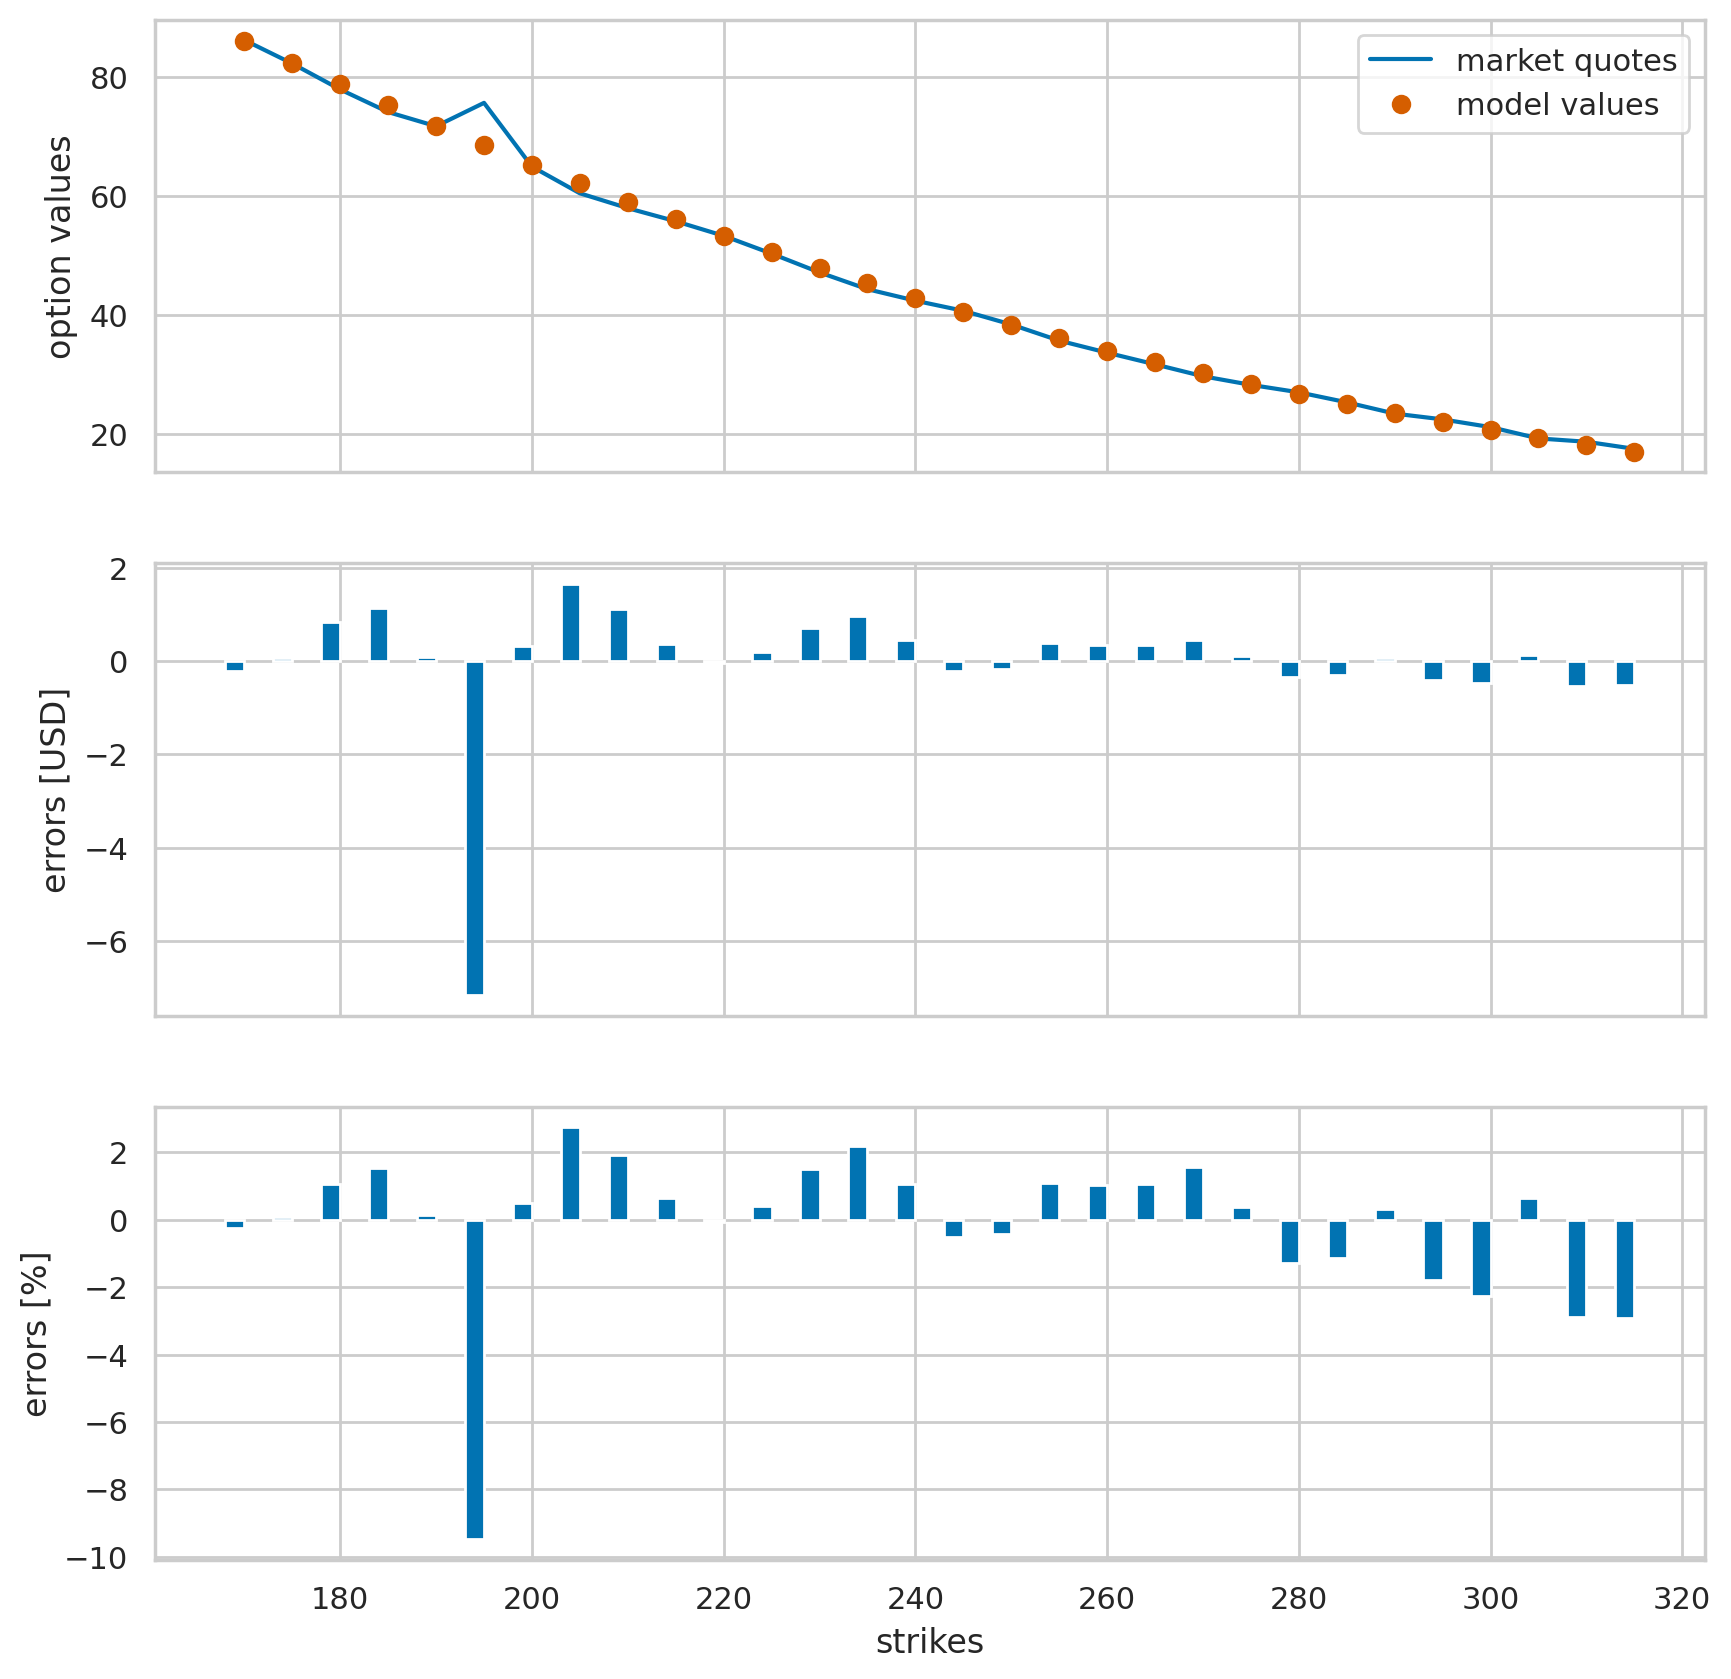

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 10))
strikes = option_selection['strike'].values
ax1.plot(strikes, option_selection['lastPrice'], label='market quotes')
ax1.plot(strikes, option_selection['MODEL'], 'ro', label='model values')
ax1.set_ylabel('option values')
ax1.legend(loc=0)
wi = 2
ax2.bar(strikes - wi / 2., option_selection['ERRORS_USD'], width=wi)
ax2.set_ylabel('errors [USD]')
ax3.bar(strikes - wi / 2., option_selection['ERRORS_%'], width=wi)
ax3.set_ylabel('errors [%]')
ax3.set_xlabel('strikes');

# Portfolio Valuation
## Modelling Option Positions

In [28]:
me_tsla = dx.market_environment('me_tsla', pricing_date)
me_tsla.add_constant('initial_value', initial_value)
me_tsla.add_constant('final_date', pricing_date)
me_tsla.add_constant('currency', 'USD')

In [29]:
# adds the optimal parameters from the calibration
me_tsla.add_constant('volatility', opt_local[0])
me_tsla.add_constant('lambda', opt_local[1])
me_tsla.add_constant('mu', opt_local[2])
me_tsla.add_constant('delta', opt_local[3])

In [30]:
me_tsla.add_constant('model', 'jd')

In [31]:
payoff_func = 'np.maximum(strike - instrument_values, 0)'

In [32]:
shared = dx.market_environment('share', pricing_date)
shared.add_constant('maturity', maturity)
shared.add_constant('currency', 'USD')

In [33]:
option_positions = {}
option_environments = {}
for option in option_selection.index:
    option_environments[option] = dx.market_environment('am_put_%d' % option, pricing_date)
    strike = option_selection['strike'].loc[option]
    option_environments[option].add_constant('strike', strike)
    option_environments[option].add_environment(shared)
    option_positions['am_put_%d' % strike] = dx.derivatives_position('am_put_%d' % strike, 
                                                                     quantity=np.random.randint(10, 50), 
                                                                     underlying='tsla_model', 
                                                                     mar_env=option_environments[option], 
                                                                     otype='American', 
                                                                     payoff_func=payoff_func)

## Options Portfolio

In [34]:
val_env = dx.market_environment('val_env', pricing_date)
val_env.add_constant('starting_date', pricing_date)
val_env.add_constant('final_date', pricing_date)
val_env.add_curve('discount_curve', csr)
val_env.add_constant('frequency', 'B')
val_env.add_constant('paths', 25_000)

In [35]:
underlyings = {'tsla_model': me_tsla}

In [36]:
portfolio = dx.derivatives_portfolio('portfolio', option_positions, val_env, underlyings)

In [37]:
%time results = portfolio.get_statistics(fixed_seed=True)

CPU times: user 1min 22s, sys: 52.3 s, total: 2min 14s
Wall time: 1min 11s


In [38]:
results.round(1)

,name,quant,value,curr,pos_value,pos_delta,pos_vega
0,am_put_170,21,9.8,USD,205.6,-2.4,439.2
1,am_put_175,17,11.0,USD,187.0,-2.3,412.0
2,am_put_180,26,12.3,USD,319.5,-3.8,485.5
3,am_put_185,23,13.6,USD,313.0,-3.4,492.0
4,am_put_190,39,15.0,USD,584.5,-6.3,1228.5
5,am_put_195,40,16.5,USD,660.5,-7.3,1144.5
6,am_put_200,39,18.2,USD,708.5,-7.9,1226.8
7,am_put_205,13,20.0,USD,259.9,-3.0,474.2
8,am_put_210,19,21.9,USD,415.8,-4.7,630.0
9,am_put_215,19,23.9,USD,453.5,-5.0,727.8


In [39]:
results[['pos_value', 'pos_delta', 'pos_vega']].sum().round(1)

pos_value    34636.6
pos_delta     -315.5
pos_vega     35164.1
dtype: float64